In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import re
import regex
from collections import Counter

import matplotlib.pyplot as plt

from wordcloud import WordCloud

### Data observation

> Retrieve the song data from the file provided

In [2]:
songs_df = pd.read_csv('Songs.csv', header = 0)
songs_df.head(5)

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...
3,Taylor Swift,the 1,"I'm doing good, I'm on some new shit\nBeen say..."
4,Taylor Swift,Look What You Made Me Do,I don't like your little games\nDon't like you...


> Each entry ends with something like '1EmbedShare URLCopyEmbedCopy', so we removed those appearances from the lyrics.

In [3]:
songs_df['Lyrics'] = songs_df['Lyrics'].str.replace(r'\d+EmbedShare URLCopyEmbedCopy$', "", regex=True)

> Show all unique artists in the dataset

In [4]:
for artist in songs_df['Artist'].unique():
    print(f'{artist}: {songs_df[songs_df['Artist'] == artist].shape[0]} Songs')

Taylor Swift: 50 Songs
Billie Eilish: 50 Songs
The Beatles: 35 Songs
David Bowie: 50 Songs
Billy Joel: 50 Songs
Ed Sheeran: 20 Songs
Eric Clapton: 50 Songs
Bruce Springsteen: 40 Songs
Vance Joy: 30 Songs
Lana Del Rey: 30 Songs
Bryan Adams: 30 Songs
Leonard Cohen: 50 Songs
Nat King Cole: 30 Songs
​twenty one pilots: 30 Songs
Ray LaMontagne: 30 Songs
Bob Dylan: 20 Songs
John Denver: 30 Songs
Frank Sinatra: 30 Songs
Queen: 30 Songs
Elton John: 30 Songs
George Michael: 30 Songs


> The dataset's size.

In [5]:
print(f'The dataset contains {len(songs_df)} entries for songs.')

The dataset contains 745 entries for songs.


> The dataset contains 3 duplicates so we will need to take care of that.

In [6]:
print(f'The dataset contains {len(songs_df['Title'].unique())} unique songs.')

The dataset contains 742 unique songs.


> Cleanup of duplicates

In [7]:
songs_df = songs_df.drop_duplicates(subset='Title')

In [8]:
for artist in songs_df['Artist'].unique():
    print(f'{artist}: {songs_df[songs_df['Artist'] == artist].shape[0]} Songs')

Taylor Swift: 50 Songs
Billie Eilish: 50 Songs
The Beatles: 35 Songs
David Bowie: 50 Songs
Billy Joel: 50 Songs
Ed Sheeran: 20 Songs
Eric Clapton: 50 Songs
Bruce Springsteen: 40 Songs
Vance Joy: 30 Songs
Lana Del Rey: 30 Songs
Bryan Adams: 30 Songs
Leonard Cohen: 50 Songs
Nat King Cole: 29 Songs
​twenty one pilots: 29 Songs
Ray LaMontagne: 30 Songs
Bob Dylan: 20 Songs
John Denver: 30 Songs
Frank Sinatra: 29 Songs
Queen: 30 Songs
Elton John: 30 Songs
George Michael: 30 Songs


> Average song length (characters & words)

In [9]:
lengths = songs_df['Lyrics'].apply(lambda x: len(x.split()))
avg_words = lengths.sum() / songs_df['Lyrics'].nunique()

char_lengths = songs_df['Lyrics'].apply(lambda x: len(x))
avg_chars = char_lengths.sum() / songs_df['Lyrics'].nunique()

print(f'The average number of words in a song is {avg_words:.2f}')
print(f'The average number of characters in a song is {avg_chars:.2f}')

The average number of words in a song is 275.94
The average number of characters in a song is 1388.24


> Word Cloud

> First we checked for abnormal characters we wanted to remove

In [10]:
# Combine all lyrics into one large text
all_lyrics = " ".join(songs_df["Lyrics"].dropna())

# Clean the text (remove punctuation, convert to lowercase)
all_lyrics = re.sub(r"[^\w\s]", "", all_lyrics.lower())

In [11]:
print(set(all_lyrics))

{'d', 'è', 'à', 'z', 's', '\n', 'é', 'م', '4', 'k', 'b', 'q', 'i', 'ê', '7', 'و', 'g', 'ö', '6', 'h', '\u2005', 'ç', 'ŏ', 'w', 'ä', 'n', '1', '5', 'ñ', '\u200a', 'f', '\u205f', 'm', 'x', 'r', 'j', 'س', '2', 'c', 'е', 'a', ' ', 't', 'ü', '9', 'ó', '0', 'ë', 'o', 'y', 'u', 'v', 'ا', 'á', 'e', '8', 'l', 'ã', 'í', '3', 'ل', 'p'}


> Tokenize and remove words that contain characters that are not latin or digits

In [12]:
# Tokenization and cleaning
words = all_lyrics.split()

# \p{L} matches any letter in any language
# \p{N} matches any numeric character
words = [word for word in words if regex.fullmatch(r"[\p{Latin}\p{N}]+", word)]

> Set up the WordCloud

The 3 most common words are:
the: 8124 appearances
you: 7105 appearances
i: 6872 appearances


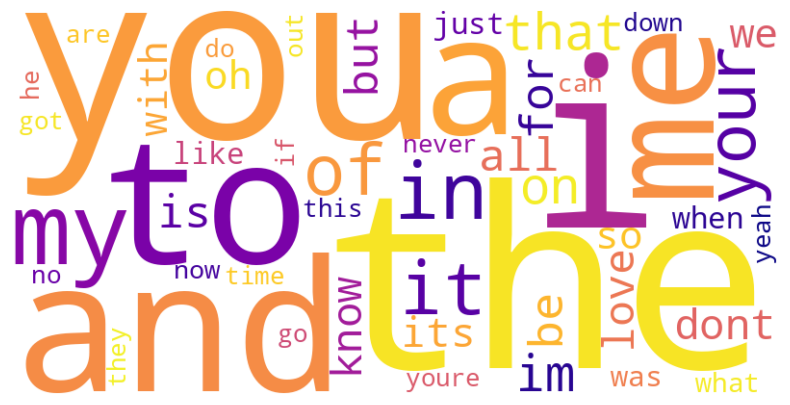

In [13]:
# Retrieve word frequencies
word_counts = Counter(words)

# 3 most common words
print("The 3 most common words are:")
for word, count in word_counts.most_common(3):
    print(f"{word}: {count} appearances")

# Definition of wordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap='plasma', max_words=50).generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Preprocessing

> Build a corpus and encode it for training

In [14]:
lyrics = songs_df["Lyrics"].dropna().str.lower()

# Remove words with unwanted characters
tokenized_lyrics = [
    [word if word != '\n' else '<newline>' for word in regex.findall(r"[\p{Latin}\p{N}]+|\n", lyric)]
    for lyric in lyrics
]

# Build vocabulary
word_counts = Counter(word for song in tokenized_lyrics for word in song)
word_to_index = {word: i + 1 for i, (word, _) in enumerate(word_counts.items())}
index_to_word = {i: word for word, i in word_to_index.items()}

# Vocabulary size
vocab_size = len(word_to_index) + 1  # Adding 1 for padding if needed

print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 9062


> We printed the filtered characters, only words with these characters are considered

In [15]:
all_chars = "".join(word for lyric in tokenized_lyrics for word in lyric)
print(sorted(set(all_chars)))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '<', '>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'á', 'ã', 'ä', 'ç', 'è', 'é', 'ê', 'ë', 'í', 'ñ', 'ó', 'ö', 'ü', 'ŏ']


In [16]:
# Convert lyrics to numerical sequences, instead of words it is now numbers (indices)
encoded_sequences = [[word_to_index[word] for word in song if word in word_to_index] for song in tokenized_lyrics]

# Set sequence length (choose a reasonable length)
# This is the number of words that the model will use to predict the next word
SEQ_LENGTH = 20

# Create input-target pairs
input_sequences = []
targets = []

# Construct all sequences and their targets
for song in encoded_sequences:
    for i in range(1, len(song)):
        n_gram_sequence = song[:i+1]                        # Create sequence up to current word
        if len(n_gram_sequence) >= 2:                       # Ensure sequence has at least one input and one target
            input_sequences.append(n_gram_sequence[:-1])    # All but last word (input)
            targets.append(n_gram_sequence[-1])             # Last word (target)

# Pad sequences to the same length (max length)
# we use 0 for padding since the indices start from 1
max_seq_length = SEQ_LENGTH
padded_sequences = [([0] * (max_seq_length - len(seq)) + seq)[-max_seq_length:] for seq in input_sequences]

# Convert to tensors
X = torch.tensor(padded_sequences, dtype=torch.long)
y = torch.tensor(targets, dtype=torch.long)

class SongLyricsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
dataset = SongLyricsDataset(X, y)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f"Dataset Size: {len(dataset)}")

Dataset Size: 251120


In [17]:
class LyricsLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=256, num_layers=4):
        super(LyricsLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Get output from last LSTM step
        return out

# Model setup
model = LyricsLSTM(vocab_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# GPU utilization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LyricsLSTM(
  (embedding): Embedding(9062, 256)
  (lstm): LSTM(256, 256, num_layers=4, batch_first=True)
  (fc): Linear(in_features=256, out_features=9062, bias=True)
)

> Train for 100 Epochs as requested

In [18]:
EPOCHS = 100

train_losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch_X, batch_y in data_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    train_losses.append(avg_loss)  # Save the average loss for this epoch
    if epoch%5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(data_loader):.4f}")


Epoch 1/100, Loss: 5.4859
Epoch 6/100, Loss: 3.0935
Epoch 11/100, Loss: 2.0846
Epoch 16/100, Loss: 1.5107
Epoch 21/100, Loss: 1.1578
Epoch 26/100, Loss: 0.9334
Epoch 31/100, Loss: 0.7931
Epoch 36/100, Loss: 0.6947
Epoch 41/100, Loss: 0.6369
Epoch 46/100, Loss: 0.5942
Epoch 51/100, Loss: 0.5582
Epoch 56/100, Loss: 0.5445
Epoch 61/100, Loss: 0.5248
Epoch 66/100, Loss: 0.5118
Epoch 71/100, Loss: 0.5026
Epoch 76/100, Loss: 0.4896
Epoch 81/100, Loss: 0.4851
Epoch 86/100, Loss: 0.4779
Epoch 91/100, Loss: 0.4758
Epoch 96/100, Loss: 0.4749


#### Optional save/load

> Save the model after training (Optional)

In [19]:
torch.save(model.state_dict(), 'lyrics_lstm_weights.pth')

> Load the model (Optional)

In [ ]:
model = LyricsLSTM(vocab_size)
model.load_state_dict(torch.load('lyrics_lstm_weights.pth'))
model.eval()

#### Visualization

> Plot the training loss

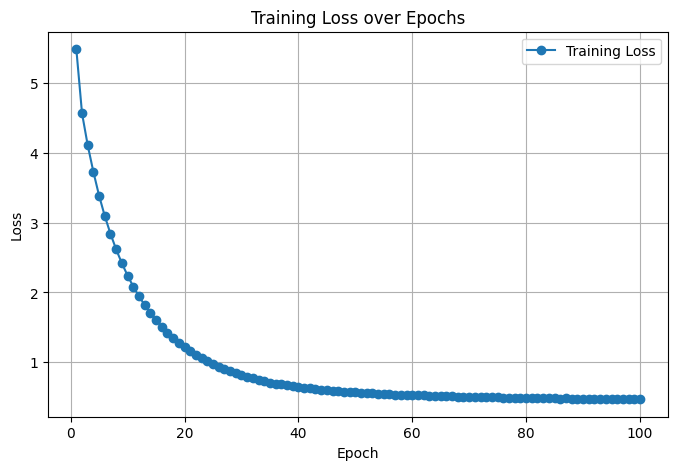

In [20]:
# Plotting the training loss after training completes
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

#### Lyrics Generator

In [21]:
def LyricsGenerator(
        starting_string, model, word_to_index, index_to_word,
        max_words=avg_words,
        strategy="",
        k= 10, p = 0.9, temperature = 1.0):
    
    model.eval()
    max_words = int(max_words)
    
    if not starting_string.strip():
        starting_word = random.choice(list(word_to_index.keys()))
        words = [starting_word]
    else:
        words = starting_string.lower().split()
    
    for _ in range(max_words):
        # Convert words to indices
        encoded_input = [word_to_index.get(word, 0) for word in words][-SEQ_LENGTH:]
        input_tensor = torch.tensor([encoded_input], dtype=torch.long).to(device)

        # Predict next word
        with torch.no_grad():
            output = model(input_tensor)
            output = output.squeeze(0)

            logits = output / temperature
            probabilities = torch.softmax(logits, dim=-1).cpu().numpy()

            if strategy == "top-k":
                top_k_indices = probabilities.argsort()[-k:][::-1]
                top_k_probs = probabilities[top_k_indices]
                top_k_probs = top_k_probs / top_k_probs.sum()  # Normalization to make a distribution
                predicted_index = np.random.choice(top_k_indices, p=top_k_probs)
            elif strategy == "top-p":
                sorted_indices = np.argsort(probabilities)[::-1]
                cumulative_probs = np.cumsum(probabilities[sorted_indices])
                top_p_indices = sorted_indices[cumulative_probs <= p]

                if len(top_p_indices) == 0:  # If no words remain, default to the word with highest probability
                    top_p_indices = [sorted_indices[0]]

                top_p_probs = probabilities[top_p_indices]
                top_p_probs = top_p_probs / top_p_probs.sum()  # Normalize to make it a valid probability distribution
                predicted_index = np.random.choice(top_p_indices, p=top_p_probs)
            elif strategy == "greedy":
                predicted_index = np.argmax(probabilities)
            else:
                predicted_index = np.random.choice(len(probabilities), p=probabilities)

        # Convert index to word
        next_word = index_to_word.get(predicted_index, "<UNK>")
        words.append(next_word)

    return " ".join(words)


#### Using top-k strategy

In [22]:
seed = "it's not a silly little moment"
generated_text = LyricsGenerator(seed, model, word_to_index, index_to_word, strategy="top-k", k=10)
generated_text = generated_text.replace('<newline>', '\n')
print("\nGenerated Lyrics:\n", generated_text)


Generated Lyrics:
 it's not a silly little moment 
 no matter what s life 
 and i m off to the races 
 cases and feeling as a whisper and the lord got out 
 all the strangers are for this one 
 got to meet that sign s old thing 
 let s make it last 
 
 let s go outside 
 let s go outside to let you start away 
 please let me start again cause we never all all wait for 
 
 oh the weather is really die 
 
 the best it s a living away 
 
 there s the music here in the mother she has found 
 i heard he can stay with me 
 
 i loved your father he loved you at every word you leave the constitution 
 and you better move the look back on the street 
 oh what a friend she ll say the half woman 
 can we talk like a window and no water 
 but the blood went out tonight 
 from the churches up in the cars 
 they re just making the garden now 
 last there s no going off again 
 once they all have some friends in the dance but it s closing different last way for the met 
 they re still the beer where

In [23]:
seed = "There is a house in"
generated_text = LyricsGenerator(seed, model, word_to_index, index_to_word, strategy="top-k", k=10)
generated_text = generated_text.replace('<newline>', '\n')
print("\nGenerated Lyrics:\n", generated_text)


Generated Lyrics:
 there is a house in the year 
 with a country old days of them is so cold 
 life for a fool when they call them a chance 
 my friend is mine and in yours when the heavens are 
 
 i am the entertainer 
 
 i am an innocent man 
 oh yes i am 
 
 some people come from 
 nothing else is awful 
 got to check this feel you 
 some people spend out to expectations 
 fight if you don t know my name 
 
 you and i do for you 
 you are so good and you give me the blues 
 when the moon s a different boy 
 you ll find that life is still worthwhile 
 if you don t have to cry alone 
 you don t even see 
 
 all the way to come back to em 
 
 to the girl of the earth when you bring big 
 every day was a singer 
 with the music kisses the reach were red leg 
 the radio on his type is plain 
 and it s been so long fantasy 
 all the way 
 you hang the look on your face 
 that someone is someone 
 you were in the vestibule 
 is the hurt 
 i got your queen and start 
 a bitter hands and th

In [36]:
seed = ""
generated_text = LyricsGenerator(seed, model, word_to_index, index_to_word, strategy="top-k", k=15)
generated_text = generated_text.replace('<newline>', '\n')
print("\nGenerated Lyrics:\n", generated_text)


Generated Lyrics:
 gasoline you 
 making it all behind 
 and that s all i love way from and 
 it could have been you 
 it s the time of submarines 
 baby yes i won t be a long way 
 thinking about all the world 
 i pick a lot of yours 
 i know that i don t know how to cuss 
 i m with you 
 i take it all behind 
 all the time i was found 
 
 oh people of the black star 
 oh that a friend is mine 
 oh these people have gone 
 and i ll do i could just understand 
 a song i ll never be strong 
 when i place this i told you 
 and in the moonlight then the next dead 
 and i hope that i wasn t there 
 
 let me let you go 
 
 quiet pretending bleedin e 
 though i m glad about you 
 god knows if we were still too late until i ve seen 
 
 i m a man so ever fear 
 the old thing ever bought 
 see scavengers for deadly 
 i believe and i still feel you in my mind 
 i would like to find through my feet 
 but you won t feel warm 
 and i d lie for you baby 
 that s all i need the strength that make a 

#### Using top-p strategy

In [37]:
seed = "it's not a silly little moment"
generated_text = LyricsGenerator(seed, model, word_to_index, index_to_word, strategy="top-p", p=0.9)
generated_text = generated_text.replace('<newline>', '\n')
print("\nGenerated Lyrics:\n", generated_text)


Generated Lyrics:
 it's not a silly little moment 
 no one has to get near 
 some lonely have died to show 
 nothing do to sing now from hatred as the lie 
 cursing my shoes i ll be here but i m gone 
 i haven t met that why i m your man 
 
 catch a good word now i ve got 
 monsters almost just a scream 
 who belonged to talk to the cops 
 for some very very too cold in the room all night 
 so meet him behind the ocean 
 got our way on my red intentions ah 
 
 and i would not leave you in 
 
 and please loves me hey what 
 high hammer out the world knocking here 
 let s make it last 
 hey boy jude else please 
 really told me not 
 he won t give us sold control to hold a lover 
 i think i m just talk with yesterday 
 
 cause she said casey can s not a reason 
 she cries a small wife but the people go 
 went down to his car 
 and he likes to be known but i think it s valentine s late 
 
 it s a kind of magic 
 it s a kind of magic 
 magic who still never seen the tears down 
 his mothe

In [39]:
seed = "There is a house in"
generated_text = LyricsGenerator(seed, model, word_to_index, index_to_word, strategy="top-p", p=0.9)
generated_text = generated_text.replace('<newline>', '\n')
print("\nGenerated Lyrics:\n", generated_text)


Generated Lyrics:
 there is a house in her eyes 
 and it seems to be a use on my hands 
 that is when i knew something over 
 
 and now i just sit in silence 
 and now i just sit in silence 
 and now i just sit 
 some people take you you for no 
 for anybody never love 
 but when i m feeling for myself 
 i ve been waiting without you 
 i still care for you 
 
 hear me out to think of something else 
 who ll be standin in the sunshine 
 you d never keep a chances 
 cause she s a beautiful leader 
 oh you could never win 
 but if you hurt me well for people if i wanted 
 if you re dark news 
 
 and all the bridges know what you ve done 
 and you re ready when you re no 
 
 just the way you look with me 
 when you are the champions to change the day 
 but if the road leads to you 
 everybody re just so joseph 
 so can t make me love 
 
 and when i m certain that i ve been out on that every week 
 that first people can t be learned 
 can t be deleted can t be repeated 
 
 it s you there l

In [48]:
seed = ""
generated_text = LyricsGenerator(seed, model, word_to_index, index_to_word, strategy="top-p", p=0.86)
generated_text = generated_text.replace('<newline>', '\n')
print("\nGenerated Lyrics:\n", generated_text)


Generated Lyrics:
 behold my always roots 
 my love on my mind 
 my boy my boy 
 my boy my love 
 you save my ground 
 i want you be this girl 
 now you re lovely with your gold of sex 
 that s how you need 
 
 and i ll always be the first old guy 
 i had to leave my life again 
 right now i go and clear 
 it is a sweet woman i ve ever known 
 except about the lines 
 planet goodbye 
 is the color where the brand i did 
 just like the same but the wave it flow 
 all i found to go again 
 
 the more that i left today 
 my body wears mine at home 
 i never heard pity through 
 you were the money to make you feel okay 
 
 the show will shake a reason not as dark 
 my body had to cut a gazely window 
 just as always as some other words but my brain babe 
 more than just like love you would miss it too better 
 so if i m living in a dream this man 
 i used to get to you one of it 
 to watch the start 
 as i used to sell what laugh i m with you 
 
 ooh 
 listen 
 nothing do you feel the ans

#### Using Greedy

In [53]:
seed = "it's not a silly little moment"
generated_text = LyricsGenerator(seed, model, word_to_index, index_to_word, strategy="greedy")
generated_text = generated_text.replace('<newline>', '\n')
print("\nGenerated Lyrics:\n", generated_text)


Generated Lyrics:
 it's not a silly little moment 
 
 i left myself into a magazine and lonely lovely queen ha 
 i heard them best n yes i took right down 
 but mama it was quiet when i knew pity 
 she said don t you know you d care 
 with your life is a mess 
 you ll be pretending and to find ourselves 
 
 
 and if the night is gone and the days are the men we d come 
 let s go here in this deep 
 let s take the breaking this heart 
 thank god i m a country boy 
 no i m not your soul 
 but i come through my face 
 i miss the whole breath of art 
 it s hard to be mad thinking 
 ah but what are i see 
 when i m low here 
 with all the years that i learned from the saints 
 i need a fix cause i m sure what s all right 
 
 hey mr tambourine man play a song for me 
 i m not sleepy and there is no place i m going to 
 hey mr tambourine man play a song for me 
 in the jingle jangle mornin i ll come followin you 
 
 i will be king there i will be return 
 but on my mind could come 
 and i wi

In [54]:
seed = "there is a house in"
generated_text = LyricsGenerator(seed, model, word_to_index, index_to_word, strategy="greedy")
generated_text = generated_text.replace('<newline>', '\n')
print("\nGenerated Lyrics:\n", generated_text)


Generated Lyrics:
 there is a house in the skin 
 for them that he picked a fire 
 he stood a nine and his size to learn in 
 janey wants a new rose 
 sounded like a new woman now 
 when i knew that it s a hard 
 but it would ve been looking to make it at without all all time 
 cause i could tell you something son 
 but i can t wait to go home 
 
 i want to be part of the light 
 i loved you 
 til you know how i gotta have to say 
 nothing left to do all now 
 you know that i m with you 
 
 i heard he spent was just a few 
 but so count 
 mary makes the diamond jive his hair 
 he just need him from the garret and crown 
 and a couple of summer she couldn t sleep but to survive 
 it s the best great to stay with me 
 
 and there s a place that i m thinking with you 
 and you remember the news so now 
 i wish there was something who knows 
 that i used to scream i was a blackstar 
 you re a tough guy 
 might have looked what s growing and all that was so far with any song 
 oh my life s

In [59]:
seed = ""
generated_text = LyricsGenerator(seed, model, word_to_index, index_to_word, strategy="greedy")
generated_text = generated_text.replace('<newline>', '\n')
print("\nGenerated Lyrics:\n", generated_text)


Generated Lyrics:
 been just up up for a moment 
 think about the good times of my life 
 
 i m in love with the shape of you 
 we push and pull like a magnet where you made me 
 hey boy let the need is mine 
 it s there for one and all for love 
 let us smile in the end 
 he s not known 
 at night when the whole world soon 
 he s been so pretty 
 but i m still at sleep as a kid about him 
 and bethlehem she says i d tell a fragment and i want to sing all the shit i was for you 
 and all the bridges are turned on the stairs i was miles 
 in the garden where the stars are out with their empty hand 
 and i miss the news we gave the news 
 
 now come to me when i m with you 
 oh darling can t you see all the other people 
 we were both on the road 
 all the young people 
 i was the very reverend mind 
 and their men and the thin now 
 i flash the entertainer 
 who is he long as they listening 
 the night will many people 
 
 how in the spiders 
 they all play our babies 
 the red they cr